# Test validity step 1 : $P(\eta | ...) \propto \eta^t (S_{approx} + E^t (B^t N^{-1} B)^{-1} E) \eta$

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import astropy.io.fits as fits
import camb
import scipy

import jax
import jax.scipy as jsp
import jax.numpy as jnp
from jax import config
config.update("jax_enable_x64", True)

import non_parametric_ML_compsep as katame

In [2]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
from func_tools_for_tests import *
from get_freq_maps_SO_64 import *
# freq_maps is defined there

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(6, 2, 49152)
(6, 2, 49152)


In [3]:
instrument

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,27.0,49.5,35.0,91.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
1,39.0,29.7,21.0,63.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
2,93.0,3.7,2.6,30.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
3,145.0,4.7,3.3,17.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
4,225.0,8.9,6.3,11.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
5,280.0,22.6,16.0,9.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT


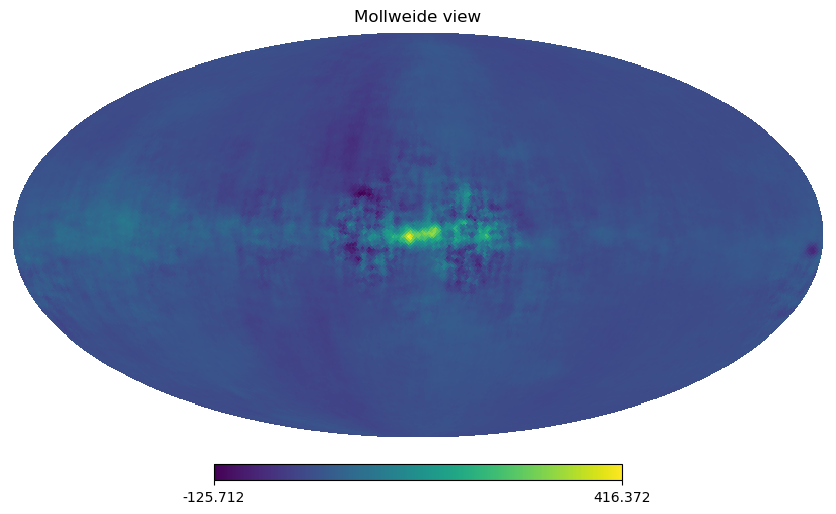

In [4]:
hp.mollview(freq_maps[0,0]) # Freq, nstokes, npix

In [5]:
nstokes = 2
nside = 64
lmax = nside*2
lmin = 2

number_frequencies = freq_maps.shape[0]
number_components = 3

limit_iter_cg=2000
tolerance_CG=10**(-12)

n_iter = 8

number_correlations = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

param_dict = {'nside':nside, 'lmax':lmax, 'nstokes':nstokes, 'number_correlations':number_correlations,'number_frequencies':number_frequencies, 'number_components':number_components}
npix = 12*nside**2

In [6]:
all_spectra = generate_power_spectra_CAMB(nside*2, typeless_bool=True)
lensing_spectra = all_spectra['lensed_scalar'][:lmax+1,:]
camb_cls = all_spectra['total'][:lmax+1,:]

c_ell_approx = np.zeros((6,lmax+1))
c_ell_approx[1] = camb_cls.T[1]
c_ell_approx[2] = lensing_spectra.T[2]


Calculating spectra from CAMB !


In [7]:
indices_polar = np.array([1,2,4])

if nstokes == 2:    
    # c_ells_input = c_ells_input[indices_polar,:]
    c_ell_approx = c_ell_approx[indices_polar,:]
    # CMB_map_input = CMB_map_input[1:,:]
    # freq_maps = freq_maps[:,1:,:]

In [8]:
all_spectra = generate_power_spectra_CAMB(nside*2, typeless_bool=True)
lensing_spectra = all_spectra['lensed_scalar'][:lmax+1,:]
camb_cls = all_spectra['total'][:lmax+1,:]

c_ells_input = np.zeros((6,lmax+1))
c_ells_input[:4,...] = camb_cls.T
c_ell_approx = np.zeros((6,lmax+1))
c_ell_approx[1] = camb_cls.T[1]
c_ell_approx[2] = lensing_spectra.T[2]


Calculating spectra from CAMB !


In [9]:
indices_polar = np.array([1,2,4])

if nstokes == 2:    
    c_ells_input = c_ells_input[indices_polar,:]
    c_ell_approx = c_ell_approx[indices_polar,:]
    # CMB_map_input = CMB_map_input[1:,:]
    # freq_maps = freq_maps[:,1:,:]

# CMB covariance preparation
red_cov_approx_matrix = katame.get_reduced_matrix_from_c_ell(c_ell_approx)[lmin:,...]
red_cov_matrix = katame.get_reduced_matrix_from_c_ell(c_ells_input)[lmin:,...]

# Mixing matrix initialization
init_mixing_matrix_obj = katame.InitMixingMatrix(np.array(instrument['frequency']), number_components, pos_special_freqs=[-1,0])
init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = katame.MixingMatrix(instrument['frequency'], number_components, init_params, pos_special_freqs=[-1,0])
# mixing_matrix_obj.update_params(mixing_matrix_obj.params/100)
mixing_matrix_sampled = mixing_matrix_obj.get_B()


# Noise initialization
depth_p = instrument['depth_p']
freq_inverse_noise = katame.get_noise_covar(depth_p, nside)
cp_cp_noise = katame.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
cp_freq_inv_noise_sqrt = katame.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
cp_freq_inv_noise = katame.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

In [10]:
red_cov_approx_matrix.shape

(127, 2, 2)

In [11]:
%%time

# eta_maps = np.zeros((number_frequencies, nstokes, npix))
eta_maps = np.zeros((nstokes, npix))
map_random_x = []
map_random_y = []
eta_maps = katame.get_sampling_eta(param_dict, red_cov_approx_matrix, cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, initial_guess=np.copy(eta_maps), lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)


Recalculating x !
Recalculating y !
CG-Python eta sampling finished in  0 iterations !!
CPU times: user 183 ms, sys: 57.5 ms, total: 240 ms
Wall time: 106 ms


In [12]:
eta_prime_maps = katame.get_sampling_eta_prime(param_dict, red_cov_approx_matrix, cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, initial_guess=np.copy(eta_maps), lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

Recalculating x !
Recalculating y !


In [13]:



class matrix_CG(object):
    def __init__(self, func):
        self.func = func

    def __matmul__(self, x):
        return self.func(x)

def get_sampling_eta_JAX_ver(param_dict, red_cov_approx_matrix, cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_x=[], map_random_y=[], initial_guess=[], lmin=0, n_iter=8, limit_iter_cg=1000, tolerance=10**(-12)):
    """ Solve sampling step 1 : sampling eta
        Solve CG for eta term with formulation : (B^t N^{-1} B)^{1/2} eta = C_approx^(1/2) x + (B^t N^{-1} B)^{-1} B^T N^{-1/2} y

        Parameters
        ----------
        param_dict : dictionnary containing the following fields : nside, nstokes, lmax, number_frequencies
        
        red_cov_approx_matrix : correction covariance matrice (C_approx) in harmonic domain, dimension [lmin:lmax, nstokes, nstokes]
        cp_cp_noise : matrices of noise combined with mixing matrices corresponding to (B^t N^{-1} B)^{-1}, dimension [component, component]
        # cp_freq_inv_noise_sqrt : matrices of noise combined with mixing matrices corresponding to B^T N^{-1/2}, dimension [component, frequencies]

        map_random_x : set of maps 0 with mean and variance 1/(pixel_size**2), which will be used to compute eta, default [] and it will be computed by the code ; dimension [nstokes, npix]
        map_random_y : set of maps 0 with mean and variance 1/(pixel_size**2), which will be used to compute eta, default [] and it will be computed by the code ; dimension [nstokes, npix]
        
        lmin : minimum multipole to be considered, default 0
        
        n_iter : number of iterations for harmonic computations, default 8

        limit_iter_cg : maximum number of iterations for the CG, default 1000
        tolerance : CG tolerance, default 10**(-12)

        initial_guess : initial guess for the CG, default [] (which is a covnention for its initialization to 0)

        Returns
        -------
        eta maps [nstokes, npix]
    """

    # assert red_cov_approx_matrix.shape[0] == param_dict['lmax'] + 1 - lmin


    # Creation of the random maps if they are not given
    if len(map_random_x) == 0:
        print("Recalculating x !")
        map_random_x = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["nstokes"],12*param_dict["nside"]**2))
    if len(map_random_y) == 0:
        print("Recalculating y !")
        map_random_y = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["number_frequencies"],param_dict["nstokes"],12*param_dict["nside"]**2))

    # Computation of the right hand side member of the CG
    red_cov_approx_matrix_sqrt = get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix)

    # First right member : C_approx^{-1/2} x
    right_member_1 = maps_x_reduced_matrix_generalized_sqrt_sqrt(map_random_x.reshape((param_dict["nstokes"],12*param_dict["nside"]**2)), red_cov_approx_matrix_sqrt, lmin=lmin, n_iter=n_iter)

    # # Second right member : E^t (B^t N^{-1} B)^{-1} B^t N^{-1/2}
    right_member_2 = np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_y)[0] # Selecting CMB component of the random variable

    right_member = (right_member_1 + right_member_2).ravel()

    # ## Left hand side term : (E^t (B^t N^{-1} B)^{-1} B^t N^{-1/2} eta
    # func_left_term = lambda x : np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise_sqrt, x.reshape((param_dict["number_frequencies"],param_dict["nstokes"],12*param_dict["nside"]**2)))[0].ravel()
    ## Left hand side term : (E^t (B^t N^{-1} B)^{-1} B^t N^{-1/2} eta
    # func_left_term = lambda x : np.einsum('kc,csp->ksp', np.sqrt(cp_cp_noise), x.reshape((param_dict["number_components"],param_dict["nstokes"],12*param_dict["nside"]**2)))[0].ravel()

    def func_left_term(x, cp_cp_noise=cp_cp_noise, param_dict=param_dict):
        cg_variable = x.reshape((param_dict["nstokes"],12*param_dict["nside"]**2))
        x_all_components = jnp.zeros((param_dict['number_components'], cg_variable.shape[0], cg_variable.shape[1]))
        # x_all_components[0,...] = cg_variable
        x_all_components = x_all_components.at[0].set(cg_variable)
        return jnp.einsum('kc,csp->ksp', scipy.linalg.sqrtm(cp_cp_noise), x_all_components)[0].ravel()
        # return np.einsum('kc,csp->ksp', np.sqrt(cp_cp_noise), x_all_components)[0].ravel()

    jitted_func_left_term = jax.jit(func_left_term)
    


    # eta_maps, number_iterations, exit_code = generalized_cg_from_func(initial_guess.ravel(), func_left_term, right_member, limit_iter_cg=limit_iter_cg, tolerance=tolerance)
    eta_maps, number_iterations = jsp.sparse.linalg.cg(func_left_term, right_member, x0=initial_guess.ravel(), tol=tolerance, atol=tolerance, maxiter=limit_iter_cg)

    print("CG-Python eta sampling finished in ", number_iterations, "iterations !!")    

    # if exit_code != 0:
    #     print("CG didn't converge with generalized_CG for eta sampling ! Exitcode :", exit_code, flush=True)

    return eta_maps.reshape((param_dict["nstokes"],12*param_dict["nside"]**2))
    # return eta_maps.reshape((param_dict["number_frequencies"], param_dict["nstokes"],12*param_dict["nside"]**2))


In [14]:
%%time

# eta_maps = np.zeros((number_frequencies, nstokes, npix))
# eta_maps = np.zeros((nstokes, npix))
map_random_x = []
map_random_y = []


eta_maps_JAX = get_sampling_eta_JAX_ver(param_dict, red_cov_approx_matrix, cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, initial_guess=np.copy(np.zeros((nstokes, npix))), lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)


Recalculating x !
Recalculating y !
CG-Python eta sampling finished in  None iterations !!
CPU times: user 632 ms, sys: 175 ms, total: 807 ms
Wall time: 473 ms


In [15]:
eta_maps_extended = np.vstack([np.zeros_like(eta_maps[0]), eta_maps])
c_ells_eta = hp.anafast(eta_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

eta_maps_extended_JAX = np.vstack([np.zeros_like(eta_maps_JAX[0]), eta_maps_JAX])
c_ells_eta_JAX = hp.anafast(eta_maps_extended_JAX, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

In [16]:
covariance_noise = np.zeros_like(c_ell_approx)
covariance_noise[:lmin,...] = scipy.linalg.sqrtm(cp_cp_noise)[0,0]*np.ones_like(c_ell_approx)[:lmin]
analytical_eta_term = (c_ell_approx + covariance_noise)/np.sqrt(cp_cp_noise[0,0])

ell_arange = np.arange(c_ell_approx.shape[1]) + lmin

In [17]:
number_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-1
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)

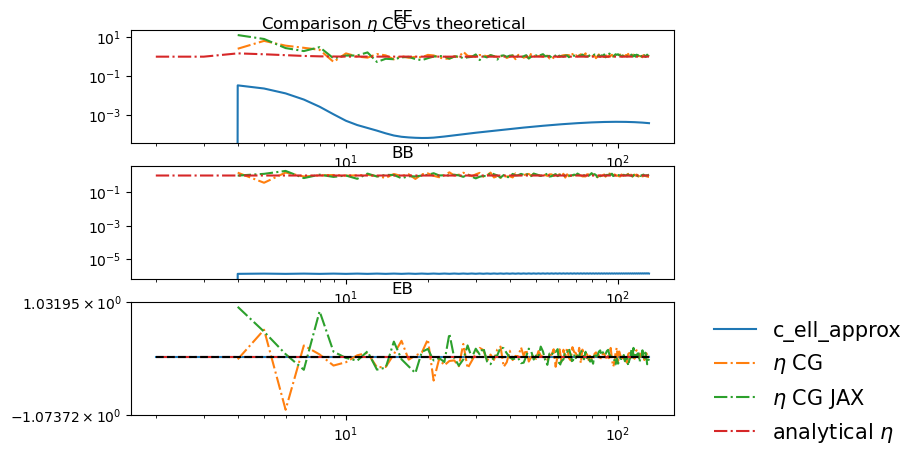

In [18]:
# list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
list_correl = ['EE', 'BB', 'EB']


plt.figure(figsize=(7,5))
plt.suptitle(r"Comparison $\eta$ CG vs theoretical", y=0.91)

for j in range(number_correl_to_plot):
    ax = plt.subplot(311+j)
    plt.title(list_correl[j])

    plt.plot(ell_arange, c_ell_approx.T[:,j], label='c_ell_approx')
    plt.plot(ell_arange[lmin:], c_ells_eta[j,:], '-.', label=r"$\eta$ CG")
    plt.plot(ell_arange[lmin:], c_ells_eta_JAX[j,:], '-.', label=r"$\eta$ CG JAX")

    plt.plot(ell_arange, analytical_eta_term[j,:], '-.', label=r"analytical $\eta$")
    
    plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')
    if nstokes == 3 and j < number_correl_to_plot-2:
        plt.xticks(color='w')

    if j <= nstokes-1:
        plt.loglog()
        # plt.ylim(ymin=noise_level/10.)
    else:
        plt.xscale('log')
        plt.yscale('symlog')
    # plt.legend()
    if j == position_legend:
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)


plt.show()

## Second CG to test

In [19]:
s_cML = np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise, freq_maps)[0,...]

In [20]:
%%time
initial_guess = np.zeros((nstokes,npix))
map_random_realization_xi = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["nstokes"],12*param_dict["nside"]**2))
map_random_realization_chi = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["number_frequencies"],param_dict["nstokes"],12*param_dict["nside"]**2))
fluctuation_maps = katame.get_fluctuating_term_maps(param_dict, red_cov_matrix, cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

CG-Python-0 Fluct finished in  266 iterations !!
CPU times: user 34.6 s, sys: 12 s, total: 46.5 s
Wall time: 13.9 s


In [21]:
%%time
initial_guess = np.zeros((nstokes,npix))
wiener_filter_term = katame.solve_generalized_wiener_filter_term(param_dict, s_cML, red_cov_matrix, cp_cp_noise, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

CG-Python-0 WF finished in  286 iterations !!
CPU times: user 36.7 s, sys: 12.8 s, total: 49.5 s
Wall time: 14.4 s


In [22]:
s_c_map = wiener_filter_term + fluctuation_maps

In [23]:
s_c_map_extended = np.zeros((number_components, nstokes, npix))
s_c_map_extended[0,...] = s_c_map

full_current_mixing_matrix = mixing_matrix_obj.get_B()


full_data_without_CMB = freq_maps - np.einsum('fc,csp->fsp',full_current_mixing_matrix, s_c_map_extended)

In [24]:
from functools import partial

def get_inverse_operators_harm_pixel_JAX(number_components, nstokes, nside, right_member, operator_harmonic, operator_pixel, initial_guess=[], lmin=2, n_iter=8, limit_iter_cg=1000, tolerance=10**(-12), with_prints=False):
    """ Solve the CG given by :
        (operator_harmonic + operator_pixel) variable = right_member

        with operator_harmonic an operator acting on harmonic domain
        with operator_pixel an operator acting on (component,pixel_domain) domain, in CMB component

        Returns
        -------
        A pixel map
        
    """

    # first_term_left = lambda x : maps_x_reduced_matrix_generalized_sqrt_sqrt(x.reshape((param_dict["nstokes"],12*param_dict["nside"]**2)), operator_harmonic, lmin=lmin, n_iter=n_iter)
    first_term_left = lambda x : maps_x_reduced_matrix_generalized_sqrt_sqrt_JAX_compatible(x.reshape((nstokes,12*nside**2)), operator_harmonic, nside=nside, lmin=lmin, n_iter=n_iter, all_params=3)
    ## Second left member : (E^t (B^t N^{-1} B)^{-1}
    # @partial(jax.jit, static_argnames=['operator_pixel','param_dict'])
    def second_term_left(x, operator_pixel=operator_pixel):
        cg_variable = x.reshape((nstokes,12*nside**2))
        x_all_components = jnp.zeros((number_components, cg_variable.shape[0], cg_variable.shape[1]))
        x_all_components = x_all_components.at[0].set(cg_variable)
        return jnp.einsum('kc,csp->ksp', operator_pixel, x_all_components)[0]

    func_left_term = lambda x : (first_term_left(x) + second_term_left(x)).ravel()

    if len(initial_guess) == 0:
        initial_guess = jnp.zeros((nstokes,12*nside**2))
    # inverse_term, number_iterations, exit_code = generalized_cg_from_func(initial_guess.ravel(), func_left_term, right_member.ravel(), limit_iter_cg=limit_iter_cg, tolerance=tolerance)
    inverse_term, number_iterations = jsp.sparse.linalg.cg(func_left_term, right_member.ravel(), x0=initial_guess.ravel(), tol=tolerance, atol=tolerance, maxiter=limit_iter_cg)
    if with_prints:
        print("CG-Python-0 WF finished in ", number_iterations, "iterations !!")
        # if exit_code != 0:
        #     print("CG didn't converge with WF ! Exitcode :", exit_code, flush=True)
    return inverse_term.reshape((nstokes, 12*nside**2))

def get_inv_BtinvNB_jax(invN, B):
    """
    B can be full Mixing Matrix, 
    or just the cmb part, 
    or just the fgs part.
    """
    BtinvNB = jnp.einsum('fc,fh,hg->cg', B, invN, B)
    invBtinvNB = jnp.linalg.inv(BtinvNB)
    
    return invBtinvNB


def get_BtinvN_jax(invN, B):
    """
    B can be full Mixing Matrix, 
    or just the cmb part, 
    or just the fgs part.
    """
    BtinvN = jnp.einsum('fc,fh->ch', B, invN)
    
    return BtinvN

def get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX(complete_mixing_matrix, full_data_without_CMB, eta_prime_maps, freq_inverse_noise, red_cov_approx_matrix, number_components, nstokes, nside, lmin, n_iter, limit_iter_cg, tolerance, with_prints=False, regularization_constant=-1, regularization_factor=10**10):
    """ Get conditional probability of mixing matrix by sampling it using emcee

        The associated conditional probability is given by : 
        - (d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d - B_c s_c)
        + \eta^t N_c^{1/2} (C_{approx} + E^t (B^T N^{-1} B)^{-1} E)^{-1} N_c^{1/2} \ \eta 
    """

    # print("Test params :", params_mixing_matrix.reshape((param_dict['number_frequencies']-2,param_dict['number_components']-1)))
    # mixingmatrix_object = mixing_matrix_obj
    # mixingmatrix_object.update_params(params_mixing_matrix.reshape((param_dict['number_frequencies']-2,param_dict['number_components']-1)))
    # mixingmatrix_object = katame.MixingMatrix(frequency_list, param_dict['number_components'], params_mixing_matrix, pos_special_freqs=pos_special_freqs)

    # Building the first term : - (d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d - B_c s_c)
    # complete_mixing_matrix_fg = mixingmatrix_object.get_B_fgs()
    complete_mixing_matrix_fg = complete_mixing_matrix[:,1:]

    cp_cp_noise_fg = get_inv_BtinvNB_jax(freq_inverse_noise, complete_mixing_matrix_fg)
    cp_freq_inv_noise_fg = get_BtinvN_jax(freq_inverse_noise, complete_mixing_matrix_fg)

    full_data_without_CMB_with_noise = jnp.einsum('cf,fsp->csp', cp_freq_inv_noise_fg, full_data_without_CMB)
    # print("Test 1 :", np.mean(full_data_without_CMB_with_noise), np.max(full_data_without_CMB_with_noise), np.min(full_data_without_CMB_with_noise), full_data_without_CMB_with_noise)
    first_term_complete = jnp.einsum('psc,cm,msp', full_data_without_CMB_with_noise.T, cp_cp_noise_fg, full_data_without_CMB_with_noise)
    # print("Test 2 :", np.mean(cp_cp_noise_fg), np.max(cp_cp_noise_fg), np.min(cp_cp_noise_fg), cp_cp_noise_fg)

    # Building the second term term \eta^t N_c^{1/2] (C_approx + E^t (B^t N^{-1} B)^{-1} E)^{-1} N_c^{1/2] \eta
    # complete_mixing_matrix = mixingmatrix_object.get_B()
    cp_cp_noise = get_inv_BtinvNB_jax(freq_inverse_noise, complete_mixing_matrix)

    ## Left hand side term : N_c^{1/2] \eta = (E^t (B^t N^{-1} B)^{-1} B^t N^{-1/2} \eta
    # noise_weighted_eta = np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise_sqrt, eta_maps)[0] # Selecting CMB component
    # eta_prime_maps_extended = jnp.array(np.zeros((param_dict['number_components'],param_dict['nstokes'],12*param_dict['nside']**2)))
    eta_prime_maps_extended = jnp.array(np.zeros((number_components,nstokes,12*nside**2)))
    # eta_prime_maps_extended[0] = eta_prime_maps
    eta_prime_maps_extended = eta_prime_maps_extended.at[0].set(eta_prime_maps)
    noise_weighted_eta = jnp.einsum('kc,csp->ksp', cp_cp_noise, eta_prime_maps_extended)[0] # Selecting CMB component

    # Then getting (C_approx + E^t (B^t N^{-1} B)^{-1} E)^{-1} N_c^{1/2] \eta
    operator_harmonic = red_cov_approx_matrix
    operator_pixel = cp_cp_noise
    inverse_term = get_inverse_operators_harm_pixel_JAX(number_components, nstokes, nside, noise_weighted_eta, operator_harmonic, operator_pixel, initial_guess=[], lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance, with_prints=with_prints)

    # And finally \eta^t N_c^{1/2] (C_approx + E^t (B^t N^{-1} B)^{-1} E)^{-1} N_c^{1/2] \eta
    # second_term_complete = np.einsum('fsk,fsk', noise_weighted_eta, inverse_term)
    second_term_complete = jnp.einsum('sk,sk', noise_weighted_eta, inverse_term)
    # print("Test", first_term_complete, second_term_complete)
    return -(-first_term_complete + second_term_complete)/2./regularization_factor + regularization_constant


In [25]:
lmax

128

In [26]:
8385/(lmax+1)

65.0

In [27]:
hp.map2alm(np.vstack([np.zeros_like(s_c_map[0]), s_c_map]), lmax=lmax, iter=n_iter).shape


(3, 8385)

In [28]:
type(hp.map2alm(np.vstack([np.zeros_like(s_c_map[0]), s_c_map]), lmax=lmax, iter=n_iter)[0,0])

numpy.complex128

In [29]:

def maps_x_reduced_matrix_generalized_sqrt_sqrt_JAX_compatible(maps_TQU_input, red_matrix_sqrt, nside, lmin=0, n_iter=8, all_params=3):
    # if lmax == -1:
    lmax = red_matrix_sqrt.shape[0] - 1 + lmin
    nstokes = red_matrix_sqrt.shape[1]
    # all_params = jnp.int16(jnp.where(nstokes > 1, 3, 1))

    # if jnp.size(maps_TQU_input.shape) == 1:
    #     nside = jnp.int64(np.sqrt(jnp.size(maps_TQU_input)/12))
    # else:
    #     nside = jnp.int64(np.sqrt(jnp.size(maps_TQU_input[0])/12))
    
    # red_sqrt_decomp = np.zeros_like(red_matrix)
    red_sqrt_decomp = jnp.zeros((lmax+1,all_params,all_params))
    if nstokes != 1:
        # red_sqrt_decomp[lmin:,3-nstokes:,3-nstokes:] = red_matrix_sqrt
        red_sqrt_decomp = red_sqrt_decomp.at[lmin:,3-nstokes:,3-nstokes:].set(red_matrix_sqrt)
    else:
        # red_sqrt_decomp[lmin:,...] = red_matrix_sqrt
        red_sqrt_decomp = red_sqrt_decomp.at[lmin:].set(red_matrix_sqrt)

    if maps_TQU_input.shape[0] == 2:
        maps_TQU = jnp.vstack((jnp.zeros_like(maps_TQU_input[0]),jnp.copy(maps_TQU_input)))
    else:
        maps_TQU = jnp.copy(maps_TQU_input)

    def wrapper_map2alm(maps_, lmax=lmax, n_iter=n_iter, nside=nside):
        alm_T, alm_E, alm_B = hp.map2alm(maps_.reshape((3, 12*nside**2)), lmax=lmax, iter=n_iter)
        return np.array([alm_T, alm_E, alm_B])
    
    def wrapper_almxfl(alm_, matrix_ell):
        return hp.almxfl(alm_, matrix_ell, inplace=False)
    
    def wrapper_alm2map(alm_, lmax=lmax, nside=nside):
        return hp.alm2map(alm_, nside, lmax=lmax)

    @partial(jax.jit, static_argnums=(1,2))
    def pure_call_map2alm(maps_, lmax, nside):
        # if jnp.size(maps_TQU_input.shape) == 1:
        #     nside = jnp.int64(np.sqrt(jnp.size(maps_TQU_input)/12))
        # else:
        #     nside = jnp.int64(np.sqrt(jnp.size(maps_TQU_input[0])/12))
        shape_output = (3,(lmax+1)*(nside+1))
        return jax.pure_callback(wrapper_map2alm, jax.ShapeDtypeStruct(shape_output, np.complex128), maps_.ravel())
    
    # @partial(jax.jit, static_argnames=['matrix_ell'])
    def pure_call_almxfl(alm_, matrix_ell):
        shape_output = [(lmax+1)*(nside+1)]
        return jax.pure_callback(wrapper_almxfl, jax.ShapeDtypeStruct(shape_output, np.complex128), alm_, matrix_ell)

    @partial(jax.jit, static_argnums=(1,2))
    def pure_call_alm2map(alm_, lmax, nside):
        # if jnp.size(maps_TQU_input.shape) == 1:
        #     nside = jnp.int64(np.sqrt(jnp.size(maps_TQU_input)/12))
        # else:
        #     nside = jnp.int64(np.sqrt(jnp.size(maps_TQU_input[0])/12))
        shape_output = (3,12*nside**2)
        return jax.pure_callback(wrapper_alm2map, jax.ShapeDtypeStruct(shape_output, np.float64), alm_)

    # alms_input = hp.map2alm(maps_TQU, lmax=lmax, iter=n_iter)
    alms_input = pure_call_map2alm(maps_TQU, lmax=lmax, nside=nside)
    # alms_input = hp.map2alm(maps_TQU, lmax=lmax, iter=n_iter)
    alms_output = jnp.zeros_like(alms_input)

    for i in range(all_params):
        alms_j = jnp.zeros_like(alms_input[i])
        for j in range(all_params):
            # alms_j += hp.almxfl(alms_input[j], red_sqrt_decomp[:,i,j], inplace=False)
            result_callback = pure_call_almxfl(alms_input[j], red_sqrt_decomp[:,i,j])
            alms_j += result_callback
        # alms_output[i] = jnp.copy(alms_j)
        alms_output = alms_output.at[i,...].set(jnp.copy(alms_j))
    # maps_output = hp.alm2map(alms_output, nside, lmax=lmax)
    maps_output = pure_call_alm2map(alms_output, nside=nside, lmax=lmax)
    if nstokes != 1:
        return maps_output[3-nstokes:,...]
    return maps_output


In [30]:
jitted_maps_x_reduced_matrix_generalized_sqrt_sqrt_JAX_compatible = jax.jit(maps_x_reduced_matrix_generalized_sqrt_sqrt_JAX_compatible, static_argnames=['red_cov_approx_matrix', 'nside', 'lmin', 'n_iter', 'all_params'])

/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/jax/_src/api_util.py:222: SyntaxWarning: Jitted function has invalid argnames {'red_cov_approx_matrix'} in static_argnames. Function does not take these args.This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has invalid argnames {invalid_argnames} "


In [31]:
%%time
test_maps = katame.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_c_map, red_cov_approx_matrix, lmin=lmin, n_iter=n_iter)



CPU times: user 128 ms, sys: 21.6 ms, total: 150 ms
Wall time: 64.6 ms


In [32]:
%%time
test_maps_JAX = jitted_maps_x_reduced_matrix_generalized_sqrt_sqrt_JAX_compatible(s_c_map, red_cov_approx_matrix, nside=nside, lmin=lmin, n_iter=n_iter, all_params=3)

CPU times: user 326 ms, sys: 68.8 ms, total: 394 ms
Wall time: 163 ms


In [33]:
test_maps_JAX.shape, test_maps.shape

((2, 49152), (2, 49152))

In [34]:
complete_mixing_matrix_fg = mixing_matrix_obj.get_B_fgs()

full_initial_guess = np.random.randn(mixing_matrix_obj.params.ravel().shape[0]).reshape(mixing_matrix_obj.params.shape)
param_init = mixing_matrix_obj.params
mixing_matrix_obj.update_params(full_initial_guess)
# Calculation value log_proba with current value of B_f

print('Init values random :', full_initial_guess)
print('True initial values :', param_init)

regularization_constant = -1
regularization_factor = 10**10

Init values random : [[ 0.59947013 -1.89321144]
 [-1.02058349 -0.69859259]
 [ 0.13677596 -0.26762922]
 [-0.74737088  0.14751532]]
True initial values : [[1.21055502e-02 1.77190420e+00]
 [5.16775485e-02 7.56410599e+00]
 [1.29207310e-01 1.89122320e+01]
 [4.40790072e-01 6.45189820e+01]]


In [35]:
eta_prime_maps_extended = np.zeros((param_dict['number_components'],param_dict['nstokes'],12*param_dict['nside']**2))
eta_prime_maps_extended[0] = eta_prime_maps
noise_weighted_eta = np.einsum('kc,csp->ksp', cp_cp_noise, eta_prime_maps_extended)[0] # Selecting CMB component
operator_harmonic = red_cov_approx_matrix
operator_pixel = cp_cp_noise

inverse_term = get_inverse_operators_harm_pixel_JAX(number_components, nstokes, nside, noise_weighted_eta, operator_harmonic, operator_pixel, initial_guess=[], lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True)

CG-Python-0 WF finished in  None iterations !!


In [36]:
%%time

# log_proba = katame.get_conditional_proba_mixing_matrix_foregrounds(mixing_matrix_obj.params, mixing_matrix_obj, full_data_without_CMB, eta_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True)
log_proba = katame.get_conditional_proba_mixing_matrix_foregrounds(np.copy(mixing_matrix_obj.params), mixing_matrix_obj, full_data_without_CMB, eta_prime_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant, regularization_factor=regularization_factor)

# mixing_matrix_obj.update_params(param_init)


CG-Python-0 WF finished in  15 iterations !!
CPU times: user 2.11 s, sys: 731 ms, total: 2.84 s
Wall time: 851 ms


In [37]:
print("Log_proba :", log_proba)
print("<-> Proba :", np.exp(log_proba))


Log_proba : -0.9847702192984468
<-> Proba : 0.37352504592360986


In [38]:
%%time

log_proba_JAX = get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX(np.copy(mixing_matrix_obj.get_B()), full_data_without_CMB, eta_prime_maps, freq_inverse_noise, red_cov_approx_matrix, number_components, nstokes, nside, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant, regularization_factor=regularization_factor)

CG-Python-0 WF finished in  None iterations !!
CPU times: user 3.45 s, sys: 734 ms, total: 4.18 s
Wall time: 1.65 s


In [39]:
print("Log_proba :", log_proba_JAX)
print("<-> Proba :", np.exp(log_proba_JAX))


Log_proba : -0.9847702192984469
<-> Proba : 0.3735250459236098


In [40]:
jitted_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX = jax.jit(get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX, static_argnames=['number_components', 'nstokes', 'nside', 'lmin', 'n_iter', 'limit_iter_cg', 'tolerance', 'with_prints', 'regularization_constant', 'regularization_factor'])

In [41]:
%%time

log_proba_JAX_jit = jitted_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX(np.copy(mixing_matrix_obj.get_B()), jnp.array(full_data_without_CMB), jnp.array(eta_prime_maps), freq_inverse_noise, red_cov_approx_matrix, number_components, nstokes, nside, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant, regularization_factor=regularization_factor)

CG-Python-0 WF finished in  None iterations !!
CPU times: user 2.74 s, sys: 322 ms, total: 3.06 s
Wall time: 1.42 s


In [42]:
print("Log_proba :", log_proba_JAX_jit)
print("<-> Proba :", np.exp(log_proba_JAX_jit))


Log_proba : -0.9847702192984469
<-> Proba : 0.3735250459236098


In [43]:
def new_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX(params_mixing_matrix, mixingmatrix_object, full_data_without_CMB, eta_prime_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin, n_iter, limit_iter_cg, tolerance_CG, with_prints=False, regularization_constant=-1, regularization_factor=10**10):
    mixingmatrix_object.update_params(params_mixing_matrix.reshape((param_dict['number_frequencies']-2,param_dict['number_components']-1)))
    return jitted_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX(np.copy(mixingmatrix_object.get_B()), jnp.array(full_data_without_CMB), jnp.array(eta_prime_maps), freq_inverse_noise, red_cov_approx_matrix, param_dict['number_components'], param_dict['nstokes'], param_dict['nside'], lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=with_prints, regularization_constant=regularization_constant, regularization_factor=regularization_factor)


In [44]:
# ver = '0a'
# filename_backend_mcmc = "validation_step_4_SO_{}_ver{}.h5".format(nside,ver)
ver = '0b'
filename_backend_mcmc = "validation_step_4_SO_{}_ver{}.h5".format(nside,ver)

In [45]:
%%time
# And now sampling B_f using emcee

n_walkers = 20
# We have 6*3 parameters to sample, trying to go with 100 steps first
number_steps_sampler = 100
with_prints = False

# whole_chain_samples = katame.sample_mixing_matrix_term(param_dict, mixing_matrix_obj, full_data_without_CMB, eta_prime_maps, red_cov_approx_matrix, freq_inverse_noise, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=10**(-12), n_walkers=n_walkers, number_steps_sampler=number_steps_sampler, with_prints=with_prints)

initial_guess_fg_mixing_matrix = mixing_matrix_obj.params.ravel()
dimensions_mixing_matrix = len(initial_guess_fg_mixing_matrix)

backend = emcee.backends.HDFBackend(filename_backend_mcmc)
backend.reset(n_walkers, dimensions_mixing_matrix) # To reset the file !

# sample_params_mixing_matrix_FG = emcee.EnsembleSampler(n_walkers, dimensions_mixing_matrix, get_conditional_proba_mixing_matrix_foregrounds, args=[mixingmatrix_object, full_data_without_CMB, eta_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin, n_iter, limit_iter_cg, tolerance, with_prints])
sample_params_mixing_matrix_FG = emcee.EnsembleSampler(n_walkers, dimensions_mixing_matrix, new_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX, args=[mixing_matrix_obj, full_data_without_CMB, eta_prime_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin, n_iter, limit_iter_cg, tolerance_CG, with_prints], backend=backend)

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(number_steps_sampler)

# This will be useful to testing convergence
old_tau = np.inf

# Initial guess
# full_initial_guess = np.random.randn(n_walkers,dimensions_mixing_matrix)
full_initial_guess = np.random.uniform(low=initial_guess_fg_mixing_matrix*.25,high=initial_guess_fg_mixing_matrix*.75, size=(n_walkers,dimensions_mixing_matrix))


# final_position_walkers = sample_params_mixing_matrix_FG.run_mcmc(full_initial_guess, number_steps_sampler)

# Now we'll sample for up to number_steps_sampler steps
for sample in sample_params_mixing_matrix_FG.sample(full_initial_guess, iterations=number_steps_sampler, progress=True):
    # Only check convergence every 100 steps
    if sample_params_mixing_matrix_FG.iteration % 100:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sample_params_mixing_matrix_FG.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 100 < sample_params_mixing_matrix_FG.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau


100%|██████████| 100/100 [13:26<00:00,  8.06s/it]

CPU times: user 1h 20min 26s, sys: 9min 22s, total: 1h 29min 48s
Wall time: 13min 38s
